In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Changing default dir
os.chdir("/Users/pedroteche/Documents/GitHub/maize-crop-diagnose/")

# Pandas options
pd.set_option("display.max_columns", 500)
# Plotting options
import warnings

warnings.filterwarnings("ignore")

In [4]:
import pyarrow

# Exploring Data

Text(0.5, 1.0, 'Healthy :(480, 640)')

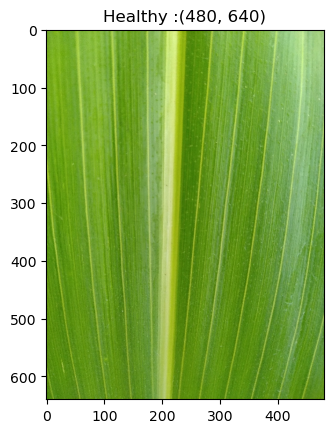

In [5]:
img = tf.keras.utils.load_img("data/raw/healthy/Image_1.jpg")
plt.imshow(img)
plt.title(f"Healthy :{img.size}")

Text(0.5, 1.0, 'MLN: (480, 640)')

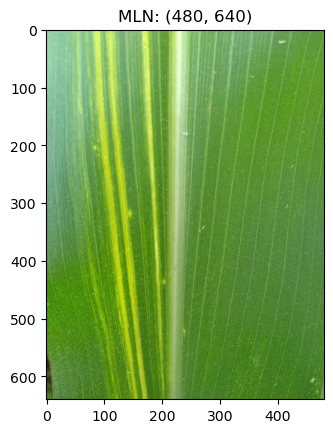

In [6]:
img = tf.keras.utils.load_img("data/raw/mln/Image_1.jpg")
plt.imshow(img)
plt.title(f"MLN: {img.size}")

Text(0.5, 1.0, 'MSV 1: (480, 640)')

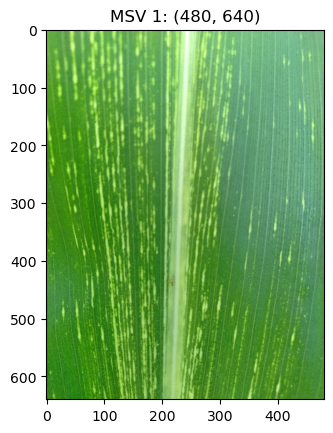

In [9]:
img = tf.keras.utils.load_img("data/raw/msv/Image_1.jpg")
plt.imshow(img)
plt.title(f"MSV 1: {img.size}")

## Converting images to TF data

In [10]:
batch_size = 32
img_height = 64 * 2
img_width = 48 * 2
data_dir = "data/raw/"

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 15350 files belonging to 3 classes.
Using 12280 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 15350 files belonging to 3 classes.
Using 3070 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'mln', 'msv']


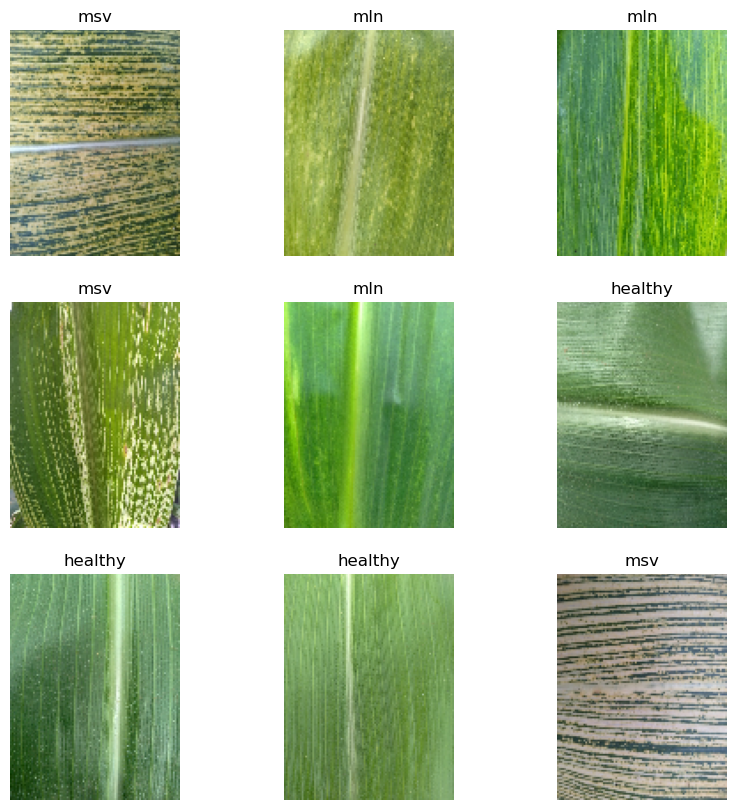

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [23]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
147/384 [==========>...................] - ETA: 9s - loss: 0.4866 - accuracy: 0.7957

2023-05-24 10:27:07.403056: E tensorflow/core/lib/jpeg/jpeg_mem.cc:324] Premature end of JPEG data. Stopped at line 478/640


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[ArgMax/_20]]
  (1) INVALID_ARGUMENT:  jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1182]